In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

In [2]:
news_df = pd.read_csv('online-news-popularity-ceu-ml-2024/train.csv')
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29733 entries, 0 to 29732
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timedelta                      29733 non-null  int64  
 1   n_tokens_title                 29733 non-null  int64  
 2   n_tokens_content               29733 non-null  int64  
 3   n_unique_tokens                29733 non-null  float64
 4   n_non_stop_words               29733 non-null  float64
 5   n_non_stop_unique_tokens       29733 non-null  float64
 6   num_hrefs                      29733 non-null  int64  
 7   num_self_hrefs                 29733 non-null  int64  
 8   num_imgs                       29733 non-null  int64  
 9   num_videos                     29733 non-null  int64  
 10  average_token_length           29733 non-null  float64
 11  num_keywords                   29733 non-null  int64  
 12  data_channel_is_lifestyle      29733 non-null 

In [3]:
news_df.head(10)

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,article_id
0,594,9,702,0.454545,1.0,0.620438,11,2,1,0,...,1.000000,-0.153395,-0.4,-0.100000,0.000000,0.000000,0.500000,0.000000,0,1
1,346,8,1197,0.470143,1.0,0.666209,21,6,2,13,...,1.000000,-0.308167,-1.0,-0.100000,0.000000,0.000000,0.500000,0.000000,0,3
2,484,9,214,0.618090,1.0,0.748092,5,2,1,0,...,0.433333,-0.141667,-0.2,-0.050000,0.000000,0.000000,0.500000,0.000000,0,5
3,639,8,249,0.621951,1.0,0.664740,16,5,8,0,...,0.500000,-0.500000,-0.8,-0.400000,0.000000,0.000000,0.500000,0.000000,0,6
4,177,12,1219,0.397841,1.0,0.583578,21,1,1,2,...,0.800000,-0.441111,-1.0,-0.050000,0.000000,0.000000,0.500000,0.000000,0,7
5,568,7,126,0.723577,1.0,0.774194,3,3,1,0,...,0.285714,0.000000,0.0,0.000000,0.454545,0.136364,0.045455,0.136364,0,8
6,318,12,1422,0.367994,1.0,0.469256,28,28,26,0,...,0.700000,-0.234167,-0.5,-0.050000,1.000000,0.100000,0.500000,0.100000,0,9
7,582,6,1102,0.451287,1.0,0.642089,7,3,1,0,...,0.800000,-0.151630,-0.4,-0.050000,0.800000,0.400000,0.300000,0.400000,1,11
8,269,9,0,0.000000,0.0,0.000000,0,0,5,0,...,0.000000,0.000000,0.0,0.000000,0.500000,0.500000,0.000000,0.500000,0,12
9,567,7,94,0.755319,1.0,0.812500,8,6,0,11,...,1.000000,-0.183333,-0.2,-0.166667,0.000000,0.000000,0.500000,0.000000,0,14


Data Cleaning

In [4]:
news_df.describe().T

,count,mean,std,min,25%,50%,75%,max
timedelta,29733.0,355.645646,214.288261,8.0,164.000000,342.000000,545.000000,731.0
n_tokens_title,29733.0,10.390812,2.110135,2.0,9.000000,10.000000,12.000000,23.0
n_tokens_content,29733.0,545.008274,469.358037,0.0,246.000000,409.000000,712.000000,8474.0
n_unique_tokens,29733.0,0.555076,4.064572,0.0,0.471400,0.539894,0.609375,701.0
n_non_stop_words,29733.0,1.005852,6.039655,0.0,1.000000,1.000000,1.000000,1042.0
...,...,...,...,...,...,...,...,...
title_sentiment_polarity,29733.0,0.069691,0.264379,-1.0,0.000000,0.000000,0.136364,1.0
abs_title_subjectivity,29733.0,0.341427,0.188735,0.0,0.166667,0.500000,0.500000,0.5
abs_title_sentiment_polarity,29733.0,0.155234,0.225066,0.0,0.000000,0.000000,0.250000,1.0
is_popular,29733.0,0.121649,0.326886,0.0,0.000000,0.000000,0.000000,1.0


In [5]:
# news_df[(news_df.n_tokens_content == 0) & (news_df.num_imgs == 0) & (news_df.num_videos == 0)]
news_df[(news_df.n_tokens_content == 0) & (news_df.num_self_hrefs > 0)]

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,article_id


EDA

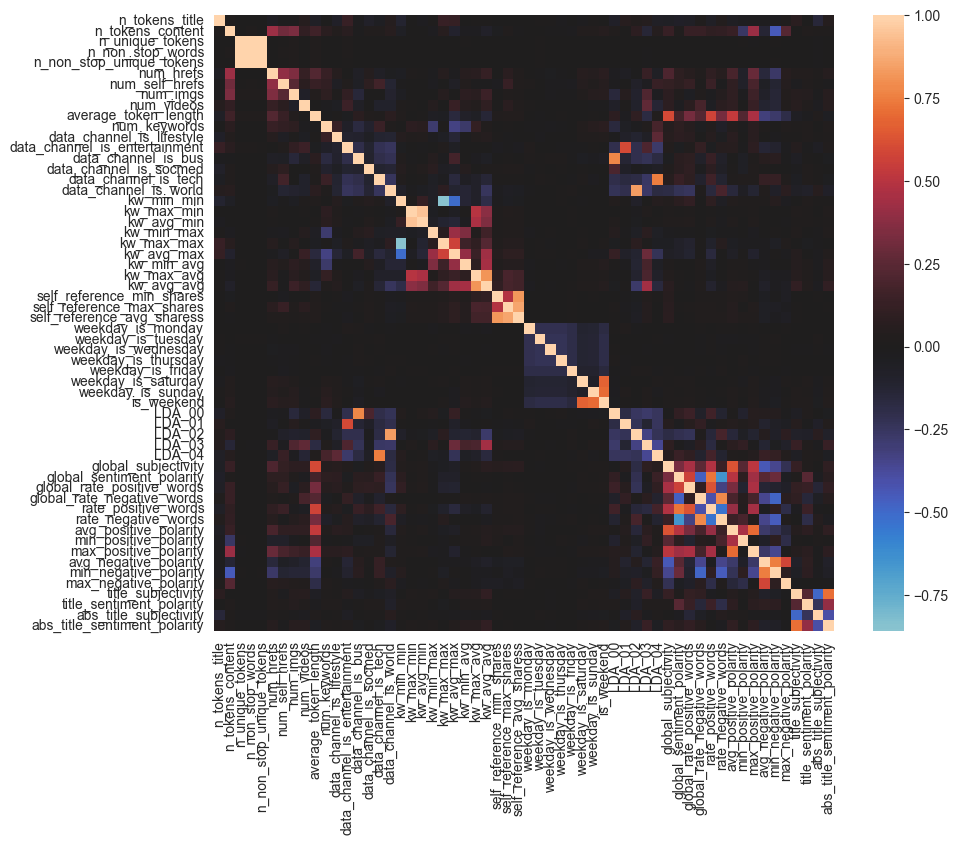

In [6]:
# correlation check 
import seaborn as sns
import matplotlib.pyplot as plt

# plot_data = news_df[[col for col in news_df.columns if col.startswith('kw_') or 'word' in col or 'polarity' in col or 'subjectivity' in col]].corr()
plot_data = news_df.drop(columns=['timedelta', 'is_popular', 'article_id']).corr()
labs = plot_data.columns

corr_plt, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(plot_data, xticklabels=labs, yticklabels=labs, center=0, ax=ax)
corr_plt.show()

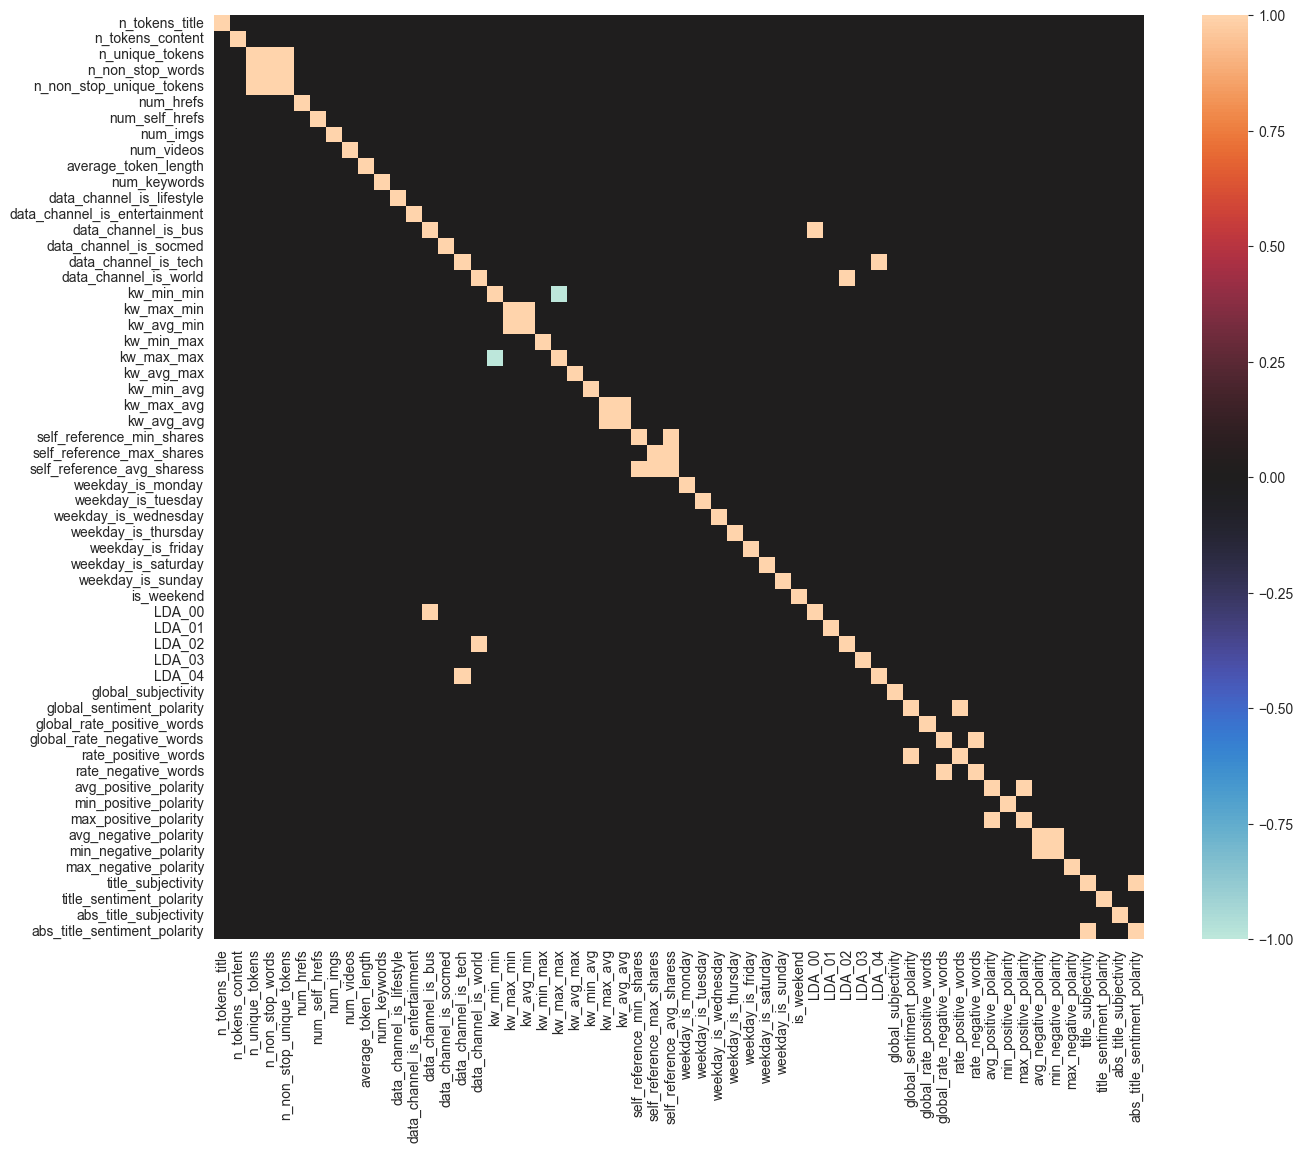

In [7]:
test_plt, ax = plt.subplots(figsize=(15, 12))
test = plot_data.applymap(lambda x: 1 if x >= 0.7 else -1 if x <= -0.7 else 0)
sns.heatmap(test, xticklabels=labs, yticklabels=labs, center=0)
test_plt.show()

In [8]:
from sklearn.model_selection import train_test_split

exclude_cols = ['timedelta', 'is_popular', 'article_id', 'kw_min_min', 'rate_positive_words', 'rate_negative_words', 'max_positive_polarity', 'min_negative_polarity', 'abs_title_sentiment_polarity'] + [col for col in news_df.columns if col.startswith('weekday_is_')]

# split data to train & val & test
outcome = news_df["is_popular"]
features = news_df.drop(columns=exclude_cols)
prng = np.random.RandomState(20240408)
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.2, random_state=prng)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=prng)

print(X_train.shape, X_val.shape, X_test.shape)

(17839, 45) (5947, 45) (5947, 45)


Simple Logit

In [9]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# no regularisation needed so setting the parameter to very high value
Cs_value_logit = [1e20]
scoring='roc_auc'

logit_model = LogisticRegressionCV(
        Cs=Cs_value_logit,
        refit=True, 
        scoring=scoring, 
        solver="liblinear", 
        tol=1e-7, 
        random_state=prng
    )

logit_model.fit(X_train, y_train)

summary_df = pd.DataFrame({'Model': ['Logit as Benchmark'],
                           'Train AUC': [round(roc_auc_score(y_train, logit_model.predict(X_train)), 4)],
                           'Val AUC': [round(roc_auc_score(y_val, logit_model.predict(X_val)), 4)],
                           'Test AUC': [round(roc_auc_score(y_test, logit_model.predict(X_test)), 4)],
                           'Train accuracy': [round(accuracy_score(y_train, logit_model.predict(X_train)), 4)],
                           'Val accuracy': [round(accuracy_score(y_val, logit_model.predict(X_val)), 4)],
                           'Test accuracy': [round(accuracy_score(y_test, logit_model.predict(X_test)), 4)],
                           'Train F1 score': [round(f1_score(y_train, logit_model.predict(X_train)), 4)],
                           'Val F1 score': [round(f1_score(y_val, logit_model.predict(X_val)), 4)],
                           'Test F1 score': [round(f1_score(y_test, logit_model.predict(X_test)), 4)],
                          })
summary_df

,Model,Train AUC,Val AUC,Test AUC,Train accuracy,Val accuracy,Test accuracy,Train F1 score,Val F1 score,Test F1 score
0,Logit as Benchmark,0.5037,0.5045,0.5046,0.8768,0.8757,0.8831,0.0179,0.0212,0.0225


Feature Engineering

In [10]:
def feature_engineer(df):
    # normalized unique tokens and keywords
    df['e_unique_tokens_normalized'] = df.apply(lambda x: x['n_unique_tokens'] / x['n_tokens_content'] if x['n_tokens_content'] > 0 else 0, axis=1)
    df['e_non_stop_unique_tokens_normalized'] = df.apply(lambda x: x['n_non_stop_unique_tokens'] / x['n_tokens_content'] if x['n_tokens_content'] > 0 else 0, axis=1)
    df['e_keyword_density'] = df.apply(lambda x: x['num_keywords'] / x['n_tokens_content'] if x['n_tokens_content'] > 0 else 0, axis=1)
    
    # links ratio
    df['e_external_link_ratio'] = df.apply(lambda x: x['num_hrefs'] / x['n_tokens_content'] if x['n_tokens_content'] > 0 else 0, axis=1)
    df['e_self_reference_link_ratio'] = df.apply(lambda x: x['num_self_hrefs'] / x['num_hrefs'] if x['num_hrefs'] > 0 else 0, axis=1)
    
    # media ratio
    df['e_multimedia_content_ratio'] = df.apply(lambda x: (x['num_imgs'] + x['num_videos']) / x['n_tokens_content'] if x['n_tokens_content'] > 0 else (x['num_imgs'] + x['num_videos']), axis=1)
    
    # composite indicators of sentiment balance or emotional intensity
    df['e_sentiment_balance'] = df['global_rate_positive_words'] - df['global_rate_negative_words']
    df['e_emotional_intensity'] = df['global_sentiment_polarity'] * df['global_subjectivity']
    
    # count of channels associated with each article
    channel_cols = [col for col in news_df.columns if col.startswith('data_channel_is')]
    df['e_num_channels'] = df[channel_cols].sum(axis=1)
    
    engineered_cols = [col for col in df.columns if col.startswith('e_')]
    
    return df, engineered_cols

news_df, engineered_cols = feature_engineer(news_df)

In [11]:
plot_data = news_df.drop(columns=['timedelta', 'is_popular', 'article_id']).corr()
test = plot_data.applymap(lambda x: 1 if x >= 0.7 else -1 if x <= -0.7 else 0)

high_correlation_pairs = []
for row_index, row in test.iterrows():
    for column_name, cell_value in row.items():
        if (cell_value == 1 or cell_value == -1) and row_index != column_name and (row_index + '*' + column_name not in high_correlation_pairs and column_name + '*' + row_index not in high_correlation_pairs):
            high_correlation_pairs.append(row_index + '*' + column_name)
high_correlation_pairs = [(x.split('*')[0], x.split('*')[1]) for x in high_correlation_pairs]
high_correlation_pairs

[('n_unique_tokens', 'n_non_stop_words'),
 ('n_unique_tokens', 'n_non_stop_unique_tokens'),
 ('n_unique_tokens', 'e_unique_tokens_normalized'),
 ('n_unique_tokens', 'e_non_stop_unique_tokens_normalized'),
 ('n_non_stop_words', 'n_non_stop_unique_tokens'),
 ('n_non_stop_words', 'e_unique_tokens_normalized'),
 ('n_non_stop_words', 'e_non_stop_unique_tokens_normalized'),
 ('n_non_stop_unique_tokens', 'e_unique_tokens_normalized'),
 ('n_non_stop_unique_tokens', 'e_non_stop_unique_tokens_normalized'),
 ('data_channel_is_bus', 'LDA_00'),
 ('data_channel_is_tech', 'LDA_04'),
 ('data_channel_is_world', 'LDA_02'),
 ('kw_min_min', 'kw_max_max'),
 ('kw_max_min', 'kw_avg_min'),
 ('kw_max_avg', 'kw_avg_avg'),
 ('self_reference_min_shares', 'self_reference_avg_sharess'),
 ('self_reference_max_shares', 'self_reference_avg_sharess'),
 ('global_sentiment_polarity', 'rate_positive_words'),
 ('global_sentiment_polarity', 'e_sentiment_balance'),
 ('global_sentiment_polarity', 'e_emotional_intensity'),
 ('

In [12]:
exclude_cols_tmp = ['n_unique_tokens','n_non_stop_words','n_non_stop_unique_tokens','kw_min_min','kw_max_min','kw_max_avg','self_reference_min_shares','self_reference_max_shares','global_sentiment_polarity','global_rate_positive_words','global_rate_negative_words','rate_positive_words','rate_negative_words','max_positive_polarity','min_negative_polarity','abs_title_sentiment_polarity'] + [col for col in news_df.columns if col.startswith('data_channel_is')]
[exclude_cols.append(x) for x in exclude_cols_tmp if x not in exclude_cols]
exclude_cols

['timedelta',
 'is_popular',
 'article_id',
 'kw_min_min',
 'rate_positive_words',
 'rate_negative_words',
 'max_positive_polarity',
 'min_negative_polarity',
 'abs_title_sentiment_polarity',
 'weekday_is_monday',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'weekday_is_saturday',
 'weekday_is_sunday',
 'n_unique_tokens',
 'n_non_stop_words',
 'n_non_stop_unique_tokens',
 'kw_max_min',
 'kw_max_avg',
 'self_reference_min_shares',
 'self_reference_max_shares',
 'global_sentiment_polarity',
 'global_rate_positive_words',
 'global_rate_negative_words',
 'data_channel_is_lifestyle',
 'data_channel_is_entertainment',
 'data_channel_is_bus',
 'data_channel_is_socmed',
 'data_channel_is_tech',
 'data_channel_is_world']

In [13]:
# split train, val, test again with engineered features
outcome = news_df["is_popular"]
features = news_df.drop(columns=exclude_cols)
prng = np.random.RandomState(20240408)
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.2, random_state=prng)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=prng)

print(X_train.shape, X_val.shape, X_test.shape)

(19028, 38) (4758, 38) (5947, 38)


In [14]:
def update_summary_score(df, model_name, train_auc, val_auc, test_auc, train_acc, val_acc, test_acc, train_f1=None, val_f1=None, test_f1=None):
    if model_name not in df.Model.values:
        df.loc[len(df.index)] = [model_name, 
                                 '{:.4f}'.format(train_auc),
                                 '{:.4f}'.format(val_auc),
                                 '{:.4f}'.format(test_auc),
                                 '{:.4f}'.format(train_acc),
                                 '{:.4f}'.format(val_acc),
                                 '{:.4f}'.format(test_acc),
                                 '{:.4f}'.format(train_f1),
                                 '{:.4f}'.format(val_f1),
                                 '{:.4f}'.format(test_f1)]
    else:
        df.loc[df.Model == model_name] = [model_name, 
                                         '{:.4f}'.format(train_auc),
                                         '{:.4f}'.format(val_auc),
                                         '{:.4f}'.format(test_auc),
                                         '{:.4f}'.format(train_acc),
                                         '{:.4f}'.format(val_acc),
                                         '{:.4f}'.format(test_acc),
                                         '{:.4f}'.format(train_f1),
                                         '{:.4f}'.format(val_f1),
                                         '{:.4f}'.format(test_f1)]
        
def update_summary(df, model_name, y_train_true, y_train_pred, y_val_true, y_val_pred, y_test_true, y_test_pred):
    if model_name not in df.Model.values:
        df.loc[len(df.index)] = [model_name, 
                                 '{:.4f}'.format(roc_auc_score(y_train_true, y_train_pred)),
                                 '{:.4f}'.format(roc_auc_score(y_val_true, y_val_pred)),
                                 '{:.4f}'.format(roc_auc_score(y_test_true, y_test_pred)),
                                 '{:.4f}'.format(accuracy_score(y_train_true, y_train_pred)),
                                 '{:.4f}'.format(accuracy_score(y_val_true, y_val_pred)),
                                 '{:.4f}'.format(accuracy_score(y_test_true, y_test_pred)),
                                 '{:.4f}'.format(f1_score(y_train_true, y_train_pred)),
                                 '{:.4f}'.format(f1_score(y_val_true, y_val_pred)),
                                 '{:.4f}'.format(f1_score(y_test_true, y_test_pred))]
    else:
        df.loc[df.Model == model_name] = [model_name, 
                                         '{:.4f}'.format(roc_auc_score(y_train_true, y_train_pred)),
                                         '{:.4f}'.format(roc_auc_score(y_val_true, y_val_pred)),
                                         '{:.4f}'.format(roc_auc_score(y_test_true, y_test_pred)),
                                         '{:.4f}'.format(accuracy_score(y_train_true, y_train_pred)),
                                         '{:.4f}'.format(accuracy_score(y_val_true, y_val_pred)),
                                         '{:.4f}'.format(accuracy_score(y_test_true, y_test_pred)),
                                         '{:.4f}'.format(f1_score(y_train_true, y_train_pred)),
                                         '{:.4f}'.format(f1_score(y_val_true, y_val_pred)),
                                         '{:.4f}'.format(f1_score(y_test_true, y_test_pred))]

Feature Engineered Logit

In [15]:
# no regularisation needed so setting the parameter to very high value
Cs_value_logit = [1e20]
scoring='roc_auc'

fe_logit_model = LogisticRegressionCV(
        Cs=Cs_value_logit,
        refit=True, 
        scoring=scoring, 
        solver="liblinear", 
        tol=1e-7, 
        random_state=prng
    )

fe_logit_model.fit(X_train, y_train)

update_summary(summary_df, 
               'FE Logit', 
               y_train, 
               fe_logit_model.predict(X_train),
               y_val, 
               fe_logit_model.predict(X_val), 
               y_test, 
               fe_logit_model.predict(X_test))
summary_df

,Model,Train AUC,Val AUC,Test AUC,Train accuracy,Val accuracy,Test accuracy,Train F1 score,Val F1 score,Test F1 score
0,Logit as Benchmark,0.5037,0.5045,0.5046,0.8768,0.8757,0.8831,0.0179,0.0212,0.0225
1,FE Logit,0.5026,0.5018,0.5058,0.8763,0.8754,0.8841,0.0142,0.0100,0.0255


In [16]:
fe_logit_coef = pd.DataFrame({
    'predictor': features.columns,
    'coef': fe_logit_model.coef_.tolist()[0]
})
fe_logit_coef['abs_coef'] = fe_logit_coef.coef.apply(lambda x: abs(x))
fe_logit_coef[(fe_logit_coef.abs_coef >= 0.01)].sort_values(by=['abs_coef'], ascending=False)

,predictor,coef,abs_coef
37,e_num_channels,-0.460820,0.460820
18,LDA_02,-0.409799,0.409799
6,average_token_length,-0.231482,0.231482
20,LDA_04,0.142002,0.142002
33,e_self_reference_link_ratio,-0.138596,0.138596
15,is_weekend,0.126985,0.126985
19,LDA_03,0.114974,0.114974
17,LDA_01,-0.109403,0.109403
21,global_subjectivity,0.103600,0.103600
26,title_subjectivity,0.087523,0.087523


In [17]:
high_performance_predictors = fe_logit_coef[(fe_logit_coef.abs_coef >= 0.01)]['predictor'].tolist()

In [18]:
high_performance_predictors;

LASSO Logit

In [19]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

lambdas = list(10**np.arange(-1, -3.01, -1/3))
n_obs = len(X_train)
Cs_values = [1/(l*n_obs) for l in lambdas]

lasso_search = LogisticRegressionCV(
    Cs = Cs_values, 
    penalty = 'l1', # L1 makes it lasso
    cv = 5, 
    refit = True, 
    scoring = scoring, 
    solver = 'liblinear',
    random_state = prng,
    # verbose=True
)

lasso_model = Pipeline(
     [('scaling', StandardScaler()),
     ("regressor", lasso_search)
     ], verbose=True
)

lasso_model.fit(X_train, y_train)

update_summary(summary_df, 
               'LASSO Logit', 
               y_train, 
               lasso_model.predict(X_train),
               y_val, 
               lasso_model.predict(X_val), 
               y_test, 
               lasso_model.predict(X_test))
summary_df

[Pipeline] ........... (step 1 of 2) Processing scaling, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.8s


,Model,Train AUC,Val AUC,Test AUC,Train accuracy,Val accuracy,Test accuracy,Train F1 score,Val F1 score,Test F1 score
0,Logit as Benchmark,0.5037,0.5045,0.5046,0.8768,0.8757,0.8831,0.0179,0.0212,0.0225
1,FE Logit,0.5026,0.5018,0.5058,0.8763,0.8754,0.8841,0.0142,0.0100,0.0255
2,LASSO Logit,0.5013,0.5004,0.5039,0.8766,0.8754,0.8840,0.0076,0.0034,0.0171


Random Forest

In [20]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

max_depth = [int(x) for x in np.linspace(1, 100, num = 5)]
max_depth.append(None)

grid = {'max_features': [0.05, 0.3, 1],
        'criterion':['gini'],
        'max_depth': max_depth,
        'min_samples_split': [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
        }

prob_forest_search = GridSearchCV(
    RandomForestClassifier(random_state = prng, oob_score=True, n_estimators=500, bootstrap=True), 
    grid, 
    cv=5, 
    refit='roc_auc',
    scoring = ['roc_auc'], 
    verbose=True,
    # random_state=prng,
    n_jobs=-1)

# RF as benchmark
rf_model = Pipeline(
    [("rf", prob_forest_search)
     ], verbose=True
)

# rf_model = RandomForestClassifier(random_state = prng, 
#                                  oob_score=True, 
#                                  n_estimators=500, 
#                                  bootstrap=True,
#                                  criterion='gini',
#                                  max_depth=50,
#                                  max_features=1,
#                                  min_samples_leaf=4,
#                                  min_samples_split=10)

rf_model.fit(X_train, y_train)
predictions_rf = rf_model.predict(X_val)
accuracy_score(y_val, predictions_rf)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[Pipeline] ................ (step 1 of 1) Processing rf, total=33.9min


0.8759983186212694

In [48]:
prob_forest_search.best_params_

{'criterion': 'gini',
 'max_depth': 50,
 'max_features': 0.05,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [22]:
update_summary(summary_df, 
               'Random Forest CV', 
               y_train, 
               rf_model.predict(X_train),
               y_val, 
               rf_model.predict(X_val), 
               y_test, 
               rf_model.predict(X_test))
summary_df

,Model,Train AUC,Val AUC,Test AUC,Train accuracy,Val accuracy,Test accuracy,Train F1 score,Val F1 score,Test F1 score
0,Logit as Benchmark,0.5037,0.5045,0.5046,0.8768,0.8757,0.8831,0.0179,0.0212,0.0225
1,FE Logit,0.5026,0.5018,0.5058,0.8763,0.8754,0.8841,0.0142,0.0100,0.0255
2,LASSO Logit,0.5013,0.5004,0.5039,0.8766,0.8754,0.8840,0.0076,0.0034,0.0171
3,Random Forest CV,0.6717,0.5000,0.5000,0.9194,0.8760,0.8838,0.5112,0.0000,0.0000


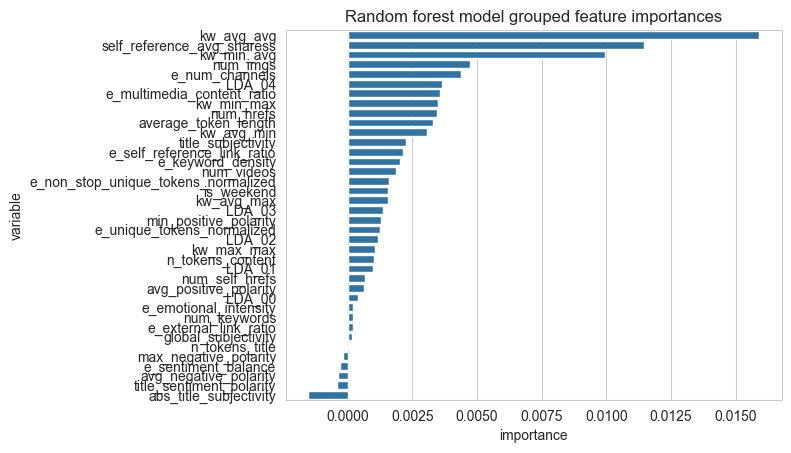

In [23]:
from sklearn.inspection import permutation_importance

rf_imp = permutation_importance(
    rf_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=prng,
    # scoring="neg_root_mean_squared_error"
)

grouped_var_imp = (pd.DataFrame(
        rf_imp.importances_mean,
        features.columns)
                      .sort_values(by = 0, ascending = False)
                      .reset_index()
                      .rename(columns={'index': 'variable', 0: 'imp'}))
grouped_var_imp['cumulative_imp'] = grouped_var_imp.imp.cumsum()

rf_fig = sns.barplot(
    data = grouped_var_imp,
    x="imp", y="variable")
rf_fig.set(title='Random forest model grouped feature importances', xlabel="importance", ylabel="variable")
plt.show()

GBM

In [24]:
from sklearn.ensemble import HistGradientBoostingClassifier

max_depth = [int(x) for x in np.linspace(1, 100, num = 4)]
max_depth.append(None)

gbm_grid = {'max_features': [0.1, 0.5, 1.0],
        'max_depth': max_depth,
        "min_samples_leaf": [5, 10, 20],
        'l2_regularization': [0, 0.001, 0.01, 0.1],
        # 'class_weight': ['balanced', None],
        'max_iter': [100, 200, 500]
        }

gbm_search = GridSearchCV(
    HistGradientBoostingClassifier(random_state = prng), 
    gbm_grid, 
    cv=5, 
    refit='roc_auc',
    scoring = ['roc_auc'], 
    verbose=True,
    # random_state=prng,
    n_jobs=-1)

# RF as benchmark
gbm_model = Pipeline(
    [("gbm", gbm_search)
     ], verbose=True
)

gbm_model.fit(X_train, y_train)
predictions_gbm = gbm_model.predict(X_val)
accuracy_score(y_val, predictions_gbm)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[Pipeline] ............... (step 1 of 1) Processing gbm, total= 1.8min


0.8759983186212694

In [25]:
gbm_search.best_params_

{'l2_regularization': 0.1,
 'max_depth': 1,
 'max_features': 0.5,
 'max_iter': 200,
 'min_samples_leaf': 5}

In [26]:
update_summary(summary_df, 
               'GBM CV', 
               y_train, 
               gbm_model.predict(X_train),
               y_val, 
               gbm_model.predict(X_val), 
               y_test, 
               gbm_model.predict(X_test))
summary_df

,Model,Train AUC,Val AUC,Test AUC,Train accuracy,Val accuracy,Test accuracy,Train F1 score,Val F1 score,Test F1 score
0,Logit as Benchmark,0.5037,0.5045,0.5046,0.8768,0.8757,0.8831,0.0179,0.0212,0.0225
1,FE Logit,0.5026,0.5018,0.5058,0.8763,0.8754,0.8841,0.0142,0.0100,0.0255
2,LASSO Logit,0.5013,0.5004,0.5039,0.8766,0.8754,0.8840,0.0076,0.0034,0.0171
3,Random Forest CV,0.6717,0.5000,0.5000,0.9194,0.8760,0.8838,0.5112,0.0000,0.0000
4,GBM CV,0.5000,0.5000,0.5000,0.8772,0.8760,0.8838,0.0000,0.0000,0.0000


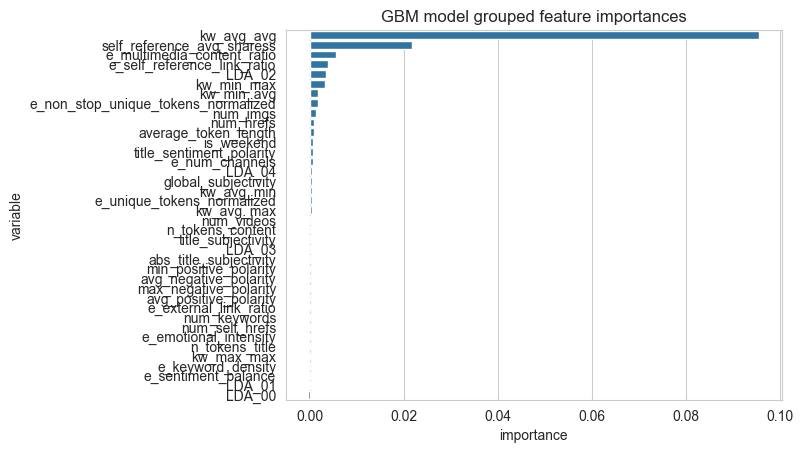

In [27]:
gbm_imp = permutation_importance(
    gbm_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=prng,
    # scoring="neg_root_mean_squared_error"
)

grouped_var_imp = (pd.DataFrame(
        gbm_imp.importances_mean,
        features.columns)
                      .sort_values(by = 0, ascending = False)
                      .reset_index()
                      .rename(columns={'index': 'variable', 0: 'imp'}))
grouped_var_imp['cumulative_imp'] = grouped_var_imp.imp.cumsum()

gbm_fig = sns.barplot(
    data = grouped_var_imp,
    x="imp", y="variable")
gbm_fig.set(title='GBM model grouped feature importances', xlabel="importance", ylabel="variable")
plt.show()

GBM w. SMOTE

In [28]:
import imblearn
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler

max_depth = [int(x) for x in np.linspace(1, 100, num = 4)]
max_depth.append(None)

gbm_grid = {'max_features': [0.1, 0.5, 1.0],
        'max_depth': max_depth,
        "min_samples_leaf": [5, 10, 20],
        'l2_regularization': [0, 0.001, 0.01, 0.1],
        # 'class_weight': ['balanced', None],
        'max_iter': [100, 200, 500]
        }

gbm_smote_search = GridSearchCV(
    HistGradientBoostingClassifier(random_state = prng), 
    gbm_grid, 
    cv=5, 
    refit='roc_auc',
    scoring = ['roc_auc'], 
    verbose=True,
    # random_state=prng,
    n_jobs=-1)

# RF as benchmark
gbm_smote_model = imblearn.pipeline.Pipeline(
    [('over_sampling', RandomOverSampler(sampling_strategy=0.5, random_state=prng)),
     ("gbm_smote", gbm_smote_search)
     ], verbose=True
)

gbm_smote_model.fit(X_train, y_train)
predictions_gbm_smote = gbm_smote_model.predict(X_val)
accuracy_score(y_val, predictions_gbm_smote)

[Pipeline] ..... (step 1 of 2) Processing over_sampling, total=   0.0s
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[Pipeline] ......... (step 2 of 2) Processing gbm_smote, total= 9.3min


0.8589743589743589

In [29]:
update_summary(summary_df, 
               'GBM SMOTE CV', 
               y_train, 
               gbm_smote_model.predict(X_train),
               y_val, 
               gbm_smote_model.predict(X_val), 
               y_test, 
               gbm_smote_model.predict(X_test))
summary_df

,Model,Train AUC,Val AUC,Test AUC,Train accuracy,Val accuracy,Test accuracy,Train F1 score,Val F1 score,Test F1 score
0,Logit as Benchmark,0.5037,0.5045,0.5046,0.8768,0.8757,0.8831,0.0179,0.0212,0.0225
1,FE Logit,0.5026,0.5018,0.5058,0.8763,0.8754,0.8841,0.0142,0.0100,0.0255
2,LASSO Logit,0.5013,0.5004,0.5039,0.8766,0.8754,0.8840,0.0076,0.0034,0.0171
3,Random Forest CV,0.6717,0.5000,0.5000,0.9194,0.8760,0.8838,0.5112,0.0000,0.0000
4,GBM CV,0.5000,0.5000,0.5000,0.8772,0.8760,0.8838,0.0000,0.0000,0.0000
5,GBM SMOTE CV,0.9746,0.5427,0.5360,0.9913,0.8590,0.8641,0.9642,0.1767,0.1566


In [30]:
# save original X, y data
X_ori_sets = [X_train, X_val, X_test]
y_ori_sets = [y_train, y_val, y_test]

Simple NN

In [31]:
# split train, val, test again with engineered features
outcome = news_df["is_popular"]
# features = news_df[high_performance_predictors]
features = news_df.drop(columns=exclude_cols)
prng = np.random.RandomState(20240408)
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.2, random_state=prng)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=prng)

print(X_train.shape, X_val.shape, X_test.shape)

(19028, 38) (4758, 38) (5947, 38)


In [32]:
from sklearn.preprocessing import MinMaxScaler

# normalize data
# scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = StandardScaler()
scaler.fit(features)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [33]:
def plot_history(fit_history):
    plt.plot(fit_history['accuracy'], label='Training Accuracy')
    plt.plot(fit_history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [34]:
y_train_sigmoid, y_val_sigmoid, y_test_sigmoid = y_train, y_val, y_test

Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7482 - auc: 0.4450 - f1_score: 0.2215 - loss: 12.1555 - val_accuracy: 0.7942 - val_auc: 0.4304 - val_f1_score: 0.2206 - val_loss: 11.7170
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.7608 - auc: 0.4502 - f1_score: 0.2215 - loss: 11.6130 - val_accuracy: 0.8047 - val_auc: 0.4306 - val_f1_score: 0.2206 - val_loss: 11.1898
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.7766 - auc: 0.4566 - f1_score: 0.2215 - loss: 11.0854 - val_accuracy: 0.8136 - val_auc: 0.4308 - val_f1_score: 0.2206 - val_loss: 10.6740
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.7935 - auc: 0.4523 - f1_score: 0.2215 - loss: 10.5701 - val_accuracy: 0.8218 - val_auc: 0.4316 - val_f1_score: 0.2206 - val_loss: 10.1701
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7983 - auc: 0.4595 - f1_score: 0.2215 - loss: 10.0660 - val_accuracy: 0.8312 - val_auc: 0.4321 - val_f1_score: 0.2206

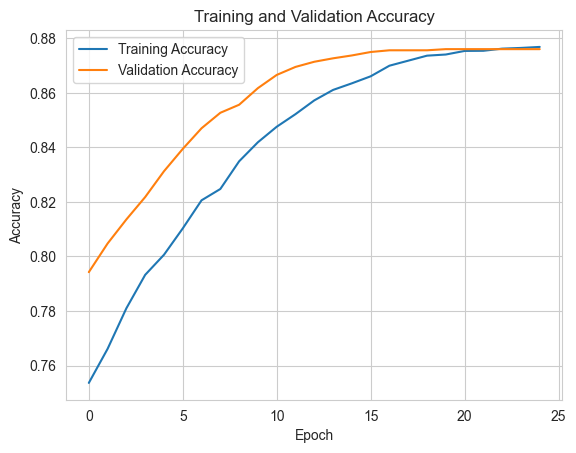

In [35]:
from keras.metrics import AUC, F1Score
from keras.models import Sequential
from keras.layers import Input, Dense, Normalization, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l1
import keras

# Build the simple fully connected single hidden layer network model
simple_model = Sequential([
    Input(shape=X_train.shape[1:]),
    # Dropout(0.2),
    # Normalization(),
    # BatchNormalization(),
    Dense(19, activation='relu', kernel_regularizer=l1(0.1)),  
    Dropout(0.3),
    # Dense(5, activation='relu'),  
    # Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
opt = Adam(learning_rate=0.0001)
simple_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[AUC(), 'accuracy', F1Score()])
# print(simple_model.summary())

# Fit the model
keras.utils.set_random_seed(20240408)  # for reproducibility
simple_history = simple_model.fit(X_train, y_train_sigmoid, validation_data=(X_val, y_val_sigmoid), epochs=200, batch_size=256, callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)], verbose=True)

# Evaluation of the model on the validation set
scores = simple_model.evaluate(X_val, y_val_sigmoid)

plot_history(simple_history.history)

In [36]:
update_summary_score(summary_df, 
               'Sigmoid NN', 
               simple_model.evaluate(X_train, y_train_sigmoid)[2], 
               scores[2], 
               simple_model.evaluate(X_test, y_test_sigmoid)[2],
               simple_model.evaluate(X_train, y_train_sigmoid)[1], 
               scores[1], 
               simple_model.evaluate(X_test, y_test_sigmoid)[1],
               simple_model.evaluate(X_train, y_train_sigmoid)[3], 
               scores[3], 
               simple_model.evaluate(X_test, y_test_sigmoid)[3])
summary_df

595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - accuracy: 0.8765 - auc: 0.4473 - f1_score: 0.2198 - loss: 2.5653
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.8781 - auc: 0.4743 - f1_score: 0.2169 - loss: 2.5625
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - accuracy: 0.8765 - auc: 0.4473 - f1_score: 0.2198 - loss: 2.5653
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - accuracy: 0.8781 - auc: 0.4743 - f1_score: 0.2169 - loss: 2.5625
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - accuracy: 0.8765 - auc: 0.4473 - f1_score: 0.2198 - loss: 2.5653
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.8781 - auc: 0.4743 - f1_score: 0.2169 - loss: 2.5625


,Model,Train AUC,Val AUC,Test AUC,Train accuracy,Val accuracy,Test accuracy,Train F1 score,Val F1 score,Test F1 score
0,Logit as Benchmark,0.5037,0.5045,0.5046,0.8768,0.8757,0.8831,0.0179,0.0212,0.0225
1,FE Logit,0.5026,0.5018,0.5058,0.8763,0.8754,0.8841,0.0142,0.0100,0.0255
2,LASSO Logit,0.5013,0.5004,0.5039,0.8766,0.8754,0.8840,0.0076,0.0034,0.0171
3,Random Forest CV,0.6717,0.5000,0.5000,0.9194,0.8760,0.8838,0.5112,0.0000,0.0000
4,GBM CV,0.5000,0.5000,0.5000,0.8772,0.8760,0.8838,0.0000,0.0000,0.0000
5,GBM SMOTE CV,0.9746,0.5427,0.5360,0.9913,0.8590,0.8641,0.9642,0.1767,0.1566
6,Sigmoid NN,0.8772,0.8760,0.8838,0.4471,0.4485,0.4549,0.2187,0.2206,0.2082


In [37]:
from keras.utils import to_categorical

print(f"Dimension of y: {y_train.shape}")

# Convert target variables to categorical
num_classes = 2
y_sets = [y_train, y_test, y_val]
y_train, y_test, y_val = [to_categorical(y, num_classes=num_classes) for y in y_sets]
print(f"Dimension of y: {y_train.shape}")

Dimension of y: (19028,)
Dimension of y: (19028, 2)


Epoch 1/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4392 - auc_1: 0.4055 - f1_score: 0.3978 - loss: 56.4251 - val_accuracy: 0.4433 - val_auc_1: 0.4101 - val_f1_score: 0.4010 - val_loss: 55.9838
Epoch 2/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.4506 - auc_1: 0.4180 - f1_score: 0.4051 - loss: 55.8721 - val_accuracy: 0.4500 - val_auc_1: 0.4209 - val_f1_score: 0.4051 - val_loss: 55.4329
Epoch 3/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.4611 - auc_1: 0.4293 - f1_score: 0.4112 - loss: 55.3163 - val_accuracy: 0.4582 - val_auc_1: 0.4315 - val_f1_score: 0.4101 - val_loss: 54.8845
Epoch 4/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.4673 - auc_1: 0.4367 - f1_score: 0.4155 - loss: 54.7746 - val_accuracy: 0.4683 - val_auc_1: 0.4422 - val_f1_score: 0.4164 - val_loss: 54.3392
Epoch 5/300
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.4802 - auc_1: 0.4508 - f1_score: 0.4230 - loss: 54.2236 - val_accuracy: 0.4775 - val_auc_

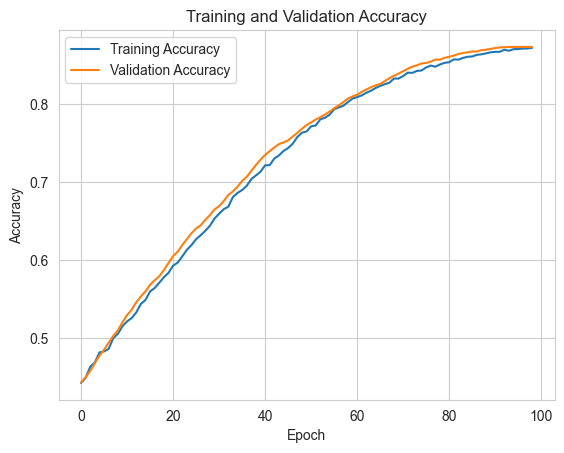

In [38]:
from keras.models import Sequential
from keras.layers import Input, Dense
import keras

# Build the simple fully connected single hidden layer network model
simple_softmax_model = Sequential([
    Input(shape=X_train.shape[1:]), 
    # Normalization(),
    Dense(19, activation='relu', kernel_regularizer=l1(0.5), kernel_initializer='glorot_normal'), 
    Dropout(0.1),
    Dense(2, activation='softmax')
])

# Compile the model
opt = Adam(learning_rate=0.00001)
simple_softmax_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[AUC(), 'accuracy', F1Score()])
# print(simple_model.summary())

# Fit the model
keras.utils.set_random_seed(20240408)  # for reproducibility
simple_softmax_history = simple_softmax_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)], batch_size=128)

# Evaluation of the model on the validation set
scores = simple_softmax_model.evaluate(X_val, y_val)

plot_history(simple_softmax_history.history)

In [39]:
update_summary_score(summary_df, 
               'Softmax NN', 
               simple_softmax_model.evaluate(X_train, y_train)[2], 
               scores[2], 
               simple_softmax_model.evaluate(X_test, y_test)[2],
               simple_softmax_model.evaluate(X_train, y_train)[1], 
               scores[1], 
               simple_softmax_model.evaluate(X_test, y_test)[1],
               simple_softmax_model.evaluate(X_train, y_train)[3].numpy()[1], 
               scores[3].numpy()[1], 
               simple_softmax_model.evaluate(X_test, y_test)[3].numpy()[1])
summary_df

595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.8741 - auc_1: 0.8887 - f1_score: 0.4701 - loss: 17.9009
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.8771 - auc_1: 0.8871 - f1_score: 0.4764 - loss: 17.9028
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.8741 - auc_1: 0.8887 - f1_score: 0.4701 - loss: 17.9009
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.8771 - auc_1: 0.8871 - f1_score: 0.4764 - loss: 17.9028
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.8741 - auc_1: 0.8887 - f1_score: 0.4701 - loss: 17.9009
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.8771 - auc_1: 0.8871 - f1_score: 0.4764 - loss: 17.9028


,Model,Train AUC,Val AUC,Test AUC,Train accuracy,Val accuracy,Test accuracy,Train F1 score,Val F1 score,Test F1 score
0,Logit as Benchmark,0.5037,0.5045,0.5046,0.8768,0.8757,0.8831,0.0179,0.0212,0.0225
1,FE Logit,0.5026,0.5018,0.5058,0.8763,0.8754,0.8841,0.0142,0.0100,0.0255
2,LASSO Logit,0.5013,0.5004,0.5039,0.8766,0.8754,0.8840,0.0076,0.0034,0.0171
3,Random Forest CV,0.6717,0.5000,0.5000,0.9194,0.8760,0.8838,0.5112,0.0000,0.0000
4,GBM CV,0.5000,0.5000,0.5000,0.8772,0.8760,0.8838,0.0000,0.0000,0.0000
5,GBM SMOTE CV,0.9746,0.5427,0.5360,0.9913,0.8590,0.8641,0.9642,0.1767,0.1566
6,Sigmoid NN,0.8772,0.8760,0.8838,0.4471,0.4485,0.4549,0.2187,0.2206,0.2082
7,Softmax NN,0.8750,0.8737,0.8815,0.8898,0.8875,0.8886,0.0125,0.0066,0.0140


SMOTE

In [40]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

smt = RandomOverSampler(sampling_strategy=0.3, random_state=prng)
X_smote, y_smote = smt.fit_resample(X_train, y_sets[0])
y_smote = to_categorical(y_smote, num_classes=num_classes)

Epoch 1/300
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4776 - auc_2: 0.4544 - f1_score: 0.4648 - loss: 56.3586 - val_accuracy: 0.4439 - val_auc_2: 0.4113 - val_f1_score: 0.4015 - val_loss: 55.9065
Epoch 2/300
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.4810 - auc_2: 0.4602 - f1_score: 0.4664 - loss: 55.7320 - val_accuracy: 0.4525 - val_auc_2: 0.4232 - val_f1_score: 0.4068 - val_loss: 55.2789
Epoch 3/300
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.4811 - auc_2: 0.4649 - f1_score: 0.4650 - loss: 55.1108 - val_accuracy: 0.4617 - val_auc_2: 0.4351 - val_f1_score: 0.4122 - val_loss: 54.6545
Epoch 4/300
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.4883 - auc_2: 0.4748 - f1_score: 0.4699 - loss: 54.4861 - val_accuracy: 0.4731 - val_auc_2: 0.4468 - val_f1_score: 0.4196 - val_loss: 54.0352
Epoch 5/300
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.4983 - auc_2: 0.4849 - f1_score: 0.4780 - loss: 53.8728 - val_accuracy: 0.4811 - val_auc_

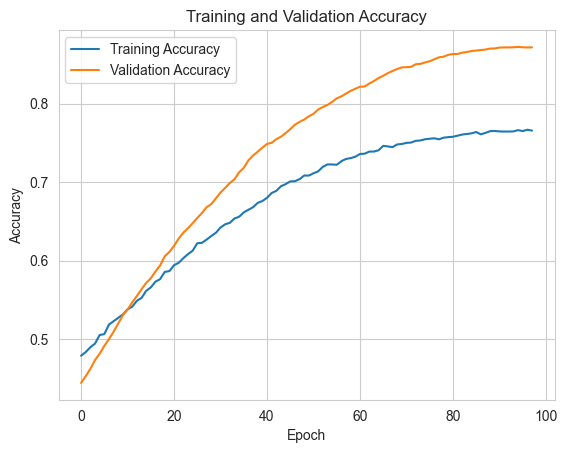

In [41]:
from sklearn.utils import compute_class_weight

# Build the simple fully connected single hidden layer network model
smote_model = Sequential([
    Input(shape=X_train.shape[1:]), 
    # BatchNormalization(),
    Dense(19, activation='relu', kernel_regularizer=l1(0.5), kernel_initializer='glorot_normal'),
    Dropout(0.1),
    # Dense(6, activation='relu'), 
    # Dropout(0.5),
    # Dense(6, activation='relu'), 
    # Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
opt = Adam(learning_rate=0.00001)
smote_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[AUC(), 'accuracy', F1Score()])

# Fit the model
keras.utils.set_random_seed(20240408)  # for reproducibility
smote_history = smote_model.fit(X_smote, y_smote, validation_data=(X_val, y_val), epochs=300, batch_size=128, callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)], verbose=True)

# Evaluation of the model on the validation set
scores = smote_model.evaluate(X_val, y_val)

plot_history(smote_history.history)

In [42]:
update_summary_score(summary_df, 
               'SMOTE NN', 
               smote_model.evaluate(X_smote, y_smote)[2], 
               scores[2], 
               smote_model.evaluate(X_test, y_test)[2],
               smote_model.evaluate(X_smote, y_smote)[1], 
               scores[1], 
               smote_model.evaluate(X_test, y_test)[1],
               smote_model.evaluate(X_smote, y_smote)[3].numpy()[1], 
               scores[3].numpy()[1], 
               smote_model.evaluate(X_test, y_test)[3].numpy()[1])
summary_df

679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.8660 - auc_2: 0.8868 - f1_score: 0.4712 - loss: 14.9795
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.8762 - auc_2: 0.8932 - f1_score: 0.4790 - loss: 14.9728
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.8660 - auc_2: 0.8868 - f1_score: 0.4712 - loss: 14.9795
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.8762 - auc_2: 0.8932 - f1_score: 0.4790 - loss: 14.9728
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.8660 - auc_2: 0.8868 - f1_score: 0.4712 - loss: 14.9795
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.8762 - auc_2: 0.8932 - f1_score: 0.4790 - loss: 14.9728


,Model,Train AUC,Val AUC,Test AUC,Train accuracy,Val accuracy,Test accuracy,Train F1 score,Val F1 score,Test F1 score
0,Logit as Benchmark,0.5037,0.5045,0.5046,0.8768,0.8757,0.8831,0.0179,0.0212,0.0225
1,FE Logit,0.5026,0.5018,0.5058,0.8763,0.8754,0.8841,0.0142,0.0100,0.0255
2,LASSO Logit,0.5013,0.5004,0.5039,0.8766,0.8754,0.8840,0.0076,0.0034,0.0171
3,Random Forest CV,0.6717,0.5000,0.5000,0.9194,0.8760,0.8838,0.5112,0.0000,0.0000
4,GBM CV,0.5000,0.5000,0.5000,0.8772,0.8760,0.8838,0.0000,0.0000,0.0000
5,GBM SMOTE CV,0.9746,0.5427,0.5360,0.9913,0.8590,0.8641,0.9642,0.1767,0.1566
6,Sigmoid NN,0.8772,0.8760,0.8838,0.4471,0.4485,0.4549,0.2187,0.2206,0.2082
7,Softmax NN,0.8750,0.8737,0.8815,0.8898,0.8875,0.8886,0.0125,0.0066,0.0140
8,SMOTE NN,0.7675,0.8718,0.8801,0.7997,0.8930,0.8939,0.0198,0.0161,0.0193


Hybrid Model

In [43]:
def get_hybrid_data(ml_model, dl_model, ml_data, dl_data):
    ml_pred = ml_model.predict_proba(ml_data)
    dl_pred = dl_model.predict(dl_data)
    df = pd.DataFrame({
        'ml_model_0': ml_pred[:,0],
        'ml_model_1': ml_pred[:,1],
        'dl_model_0': dl_pred[:,0],
        'dl_model_1': dl_pred[:,1]
    })
    return df

In [44]:
X_train_hybrid, X_val_hybrid, X_test_hybrid = get_hybrid_data(gbm_smote_model, simple_softmax_model, X_ori_sets[0], X_train), get_hybrid_data(gbm_smote_model, simple_softmax_model, X_ori_sets[1], X_val), get_hybrid_data(gbm_smote_model, simple_softmax_model, X_ori_sets[2], X_test)

# no regularisation needed so setting the parameter to very high value
lambdas = list(10**np.arange(-1, -3.01, -1/3))
n_obs = len(X_train_hybrid)
Cs_values = [1/(l*n_obs) for l in lambdas]
scoring='roc_auc'

hybrid_model = LogisticRegressionCV(
        Cs=Cs_values, 
        penalty='elasticnet',
        l1_ratios=[0, 0.3, 0.5],
        refit=True, 
        scoring=scoring, 
        solver="saga", 
        tol=1e-7, 
        random_state=prng,
        class_weight=None
    )

hybrid_model.fit(X_train_hybrid, y_ori_sets[0])

update_summary(summary_df, 
               'Hybrid Model', 
               y_ori_sets[0], 
               hybrid_model.predict(X_train_hybrid),
               y_ori_sets[1], 
               hybrid_model.predict(X_val_hybrid), 
               y_ori_sets[2], 
               hybrid_model.predict(X_test_hybrid))
summary_df

595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


,Model,Train AUC,Val AUC,Test AUC,Train accuracy,Val accuracy,Test accuracy,Train F1 score,Val F1 score,Test F1 score
0,Logit as Benchmark,0.5037,0.5045,0.5046,0.8768,0.8757,0.8831,0.0179,0.0212,0.0225
1,FE Logit,0.5026,0.5018,0.5058,0.8763,0.8754,0.8841,0.0142,0.0100,0.0255
2,LASSO Logit,0.5013,0.5004,0.5039,0.8766,0.8754,0.8840,0.0076,0.0034,0.0171
3,Random Forest CV,0.6717,0.5000,0.5000,0.9194,0.8760,0.8838,0.5112,0.0000,0.0000
4,GBM CV,0.5000,0.5000,0.5000,0.8772,0.8760,0.8838,0.0000,0.0000,0.0000
5,GBM SMOTE CV,0.9746,0.5427,0.5360,0.9913,0.8590,0.8641,0.9642,0.1767,0.1566
6,Sigmoid NN,0.8772,0.8760,0.8838,0.4471,0.4485,0.4549,0.2187,0.2206,0.2082
7,Softmax NN,0.8750,0.8737,0.8815,0.8898,0.8875,0.8886,0.0125,0.0066,0.0140
8,SMOTE NN,0.7675,0.8718,0.8801,0.7997,0.8930,0.8939,0.0198,0.0161,0.0193
9,Hybrid Model,0.9681,0.5327,0.5260,0.9905,0.8644,0.8709,0.9604,0.1434,0.1213


In [45]:
hybrid_model.coef_

array([[-5.03668887,  5.03668882,  0.1372245 , -0.13722455]])

Voting Classifier

In [46]:
ml_models = {
    # 'FE Logit': fe_logit_model,
    # 'LASSO Logit': lasso_model, 
    'Random Forest CV': rf_model,
    'GBM CV': gbm_model,
    'GBM SMOTE CV': gbm_smote_model,
}
dl_models = {
    'Softmax NN': simple_softmax_model,
    'SMOTE NN': smote_model
}

class CustomVotingClassifier:
    
    def __init__(self, ml_models: dict, dl_models: dict, voting='soft'):
        self.ml_models = ml_models
        self.dl_models = dl_models
        self.voting = voting
    
    def predict_proba(self, ml_data, dl_data):
        class_0_pred = {}
        class_1_pred = {}
        for model_name, model in self.ml_models.items():
            model_pred = model.predict_proba(ml_data)
            class_0_pred[model_name] = model_pred[:,0]
            class_1_pred[model_name] = model_pred[:,1]
        for model_name, model in self.dl_models.items():
            model_pred = model.predict(dl_data)
            class_0_pred[model_name] = model_pred[:,0]
            class_1_pred[model_name] = model_pred[:,1]
        
        pred_0_df = pd.DataFrame.from_dict(class_0_pred)
        pred_1_df = pd.DataFrame.from_dict(class_1_pred)
        
        pred_df = pd.DataFrame({
            0: pred_0_df.mean(axis=1).to_numpy(),
            1: pred_1_df.mean(axis=1).to_numpy()
        })
        return pred_df
    
    def predict(self, ml_data, dl_data):
        model_pred = {}
        if self.voting == 'soft':
            pred_df = self.predict_proba(ml_data, dl_data)
            pred_df = pred_df.idxmax(axis=1)
            return pred_df.to_numpy()
        elif self.voting == 'hard':
            for model_name, model in self.ml_models.items():
                model_pred[model_name] = model.predict(ml_data)
            for model_name, model in self.dl_models.items():
                model_pred[model_name] = np.argmax(model.predict(dl_data), axis=1)
            pred_df = pd.DataFrame.from_dict(model_pred)
            pred_df = pred_df.mode(axis=1)
            return pred_df.to_numpy()
        else:
            print('Invalid voting param!')

In [47]:
soft_voting_clf = CustomVotingClassifier(ml_models, dl_models)
hard_voting_clf = CustomVotingClassifier(ml_models, dl_models, 'hard')
update_summary(summary_df, 
               'Soft Voting Classifier', 
               y_ori_sets[0], 
               soft_voting_clf.predict(X_ori_sets[0], X_train),
               y_ori_sets[1], 
               soft_voting_clf.predict(X_ori_sets[1], X_val), 
               y_ori_sets[2], 
               soft_voting_clf.predict(X_ori_sets[2], X_test))
update_summary(summary_df, 
               'Hard Voting Classifier', 
               y_ori_sets[0], 
               hard_voting_clf.predict(X_ori_sets[0], X_train),
               y_ori_sets[1], 
               hard_voting_clf.predict(X_ori_sets[1], X_val), 
               y_ori_sets[2], 
               hard_voting_clf.predict(X_ori_sets[2], X_test))
summary_df

595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
595/595 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


,Model,Train AUC,Val AUC,Test AUC,Train accuracy,Val accuracy,Test accuracy,Train F1 score,Val F1 score,Test F1 score
0,Logit as Benchmark,0.5037,0.5045,0.5046,0.8768,0.8757,0.8831,0.0179,0.0212,0.0225
1,FE Logit,0.5026,0.5018,0.5058,0.8763,0.8754,0.8841,0.0142,0.0100,0.0255
2,LASSO Logit,0.5013,0.5004,0.5039,0.8766,0.8754,0.8840,0.0076,0.0034,0.0171
3,Random Forest CV,0.6717,0.5000,0.5000,0.9194,0.8760,0.8838,0.5112,0.0000,0.0000
4,GBM CV,0.5000,0.5000,0.5000,0.8772,0.8760,0.8838,0.0000,0.0000,0.0000
5,GBM SMOTE CV,0.9746,0.5427,0.5360,0.9913,0.8590,0.8641,0.9642,0.1767,0.1566
6,Sigmoid NN,0.8772,0.8760,0.8838,0.4471,0.4485,0.4549,0.2187,0.2206,0.2082
7,Softmax NN,0.8750,0.8737,0.8815,0.8898,0.8875,0.8886,0.0125,0.0066,0.0140
8,SMOTE NN,0.7675,0.8718,0.8801,0.7997,0.8930,0.8939,0.0198,0.0161,0.0193
9,Hybrid Model,0.9681,0.5327,0.5260,0.9905,0.8644,0.8709,0.9604,0.1434,0.1213


Predict

In [ ]:
unseen_df = pd.read_csv('online-news-popularity-ceu-ml-2024/test.csv')

In [ ]:
unseen_df, _ = feature_engineer(unseen_df)

In [ ]:
exclude_cols_test = exclude_cols.copy()

In [ ]:
if 'is_popular' in exclude_cols_test:
    exclude_cols_test.remove('is_popular')
unseen_features = unseen_df.drop(columns=exclude_cols_test)
predictions = gbm_smote_model.predict_proba(unseen_features)[:,1]
predictions[:30]

In [ ]:
if 'is_popular' in exclude_cols_test:
    exclude_cols_test.remove('is_popular')
unseen_features = unseen_df.drop(columns=exclude_cols_test)
# unseen_features = unseen_df[high_performance_predictors]
unseen_features = scaler.transform(unseen_features)
predictions = simple_softmax_model.predict(unseen_features)
# predictions = weighted_deep3_model.predict(unseen_features)
predictions = predictions[:, 1]
predictions[:30]

In [ ]:
if 'is_popular' in exclude_cols_test:
    exclude_cols_test.remove('is_popular')
unseen_features = unseen_df.drop(columns=exclude_cols_test)
X_ml_unseen = unseen_features
X_dl_unseen = scaler.transform(unseen_features)
predictions = hybrid_model.predict_proba(get_hybrid_data(gbm_smote_model, simple_softmax_model, X_ml_unseen, X_dl_unseen))[:,1]
predictions[:30]

In [ ]:
prediction_df = pd.DataFrame({
    'article_id': unseen_df.article_id,
    'score': predictions
})
# prediction_df[(prediction_df.score > 0.6)]
prediction_df.to_csv('submission.csv', index=False)

In [ ]:
news_df.is_popular.sum()/news_df.shape[0]